In [27]:
import gensim
import os
import collections
import smart_open
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import itertools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline

flatten = lambda l: [item for sublist in l for item in sublist]

In [3]:
# Set file names for train and test data
test_data_dir = 'data'
train_file = test_data_dir + os.sep + 'ingredient2vec'

def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                line_split = line.split(' ')
                ingredient = line_split[0]
                compounds = ' '.join(line_split[1:])
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(compounds), [ingredient])
                
train_corpus = list(read_corpus(train_file))
train_corpus[:10]

[TaggedDocument(words=[u'nonanone'], tags=['ruta_chalepensis_oil']),
 TaggedDocument(words=[u'butyl_butyrate'], tags=['passiflora_mollissima']),
 TaggedDocument(words=[u'thymol', u'octanone', u'pentylfuran', u'nerolidol', u'myrcene', u'formyl', u'ene', u'isopulegol', u'salicylaldehyde', u'mentha', u'dien', u'ol', u'octanal', u'methylanisole', u'veratraldehyde'], tags=['mastic_gum_oil']),
 TaggedDocument(words=[u'benzyl_alcohol'], tags=['copaiba']),
 TaggedDocument(words=[u'bornyl_acetate', u'isoamyl_alcohol'], tags=['teucrium_chamaedrys']),
 TaggedDocument(words=[u'menth', u'ene', u'al', u'piperitone', u'formyl', u'ene'], tags=['seed_oil']),
 TaggedDocument(words=[u'taurine'], tags=['octopus']),
 TaggedDocument(words=[u'phenyl', u'propanol'], tags=['storax']),
 TaggedDocument(words=[u'trimethyl', u'cyclohexa', u'dienyl', u'but', u'en', u'one'], tags=['summer_savory']),
 TaggedDocument(words=[u'diacetyl'], tags=['fagroea_racemosa_flower'])]

In [4]:
### Train Model

#dm/m,d50,n5,w5,mc5,s0.001,t3
model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=20, iter=55)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 5.13 s, sys: 1.96 s, total: 7.09 s
Wall time: 4.37 s


1367574

In [19]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(train_corpus[doc_id].tags[0])
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [20]:
collections.Counter(ranks)  # Results vary due to random seeding and very small corpus

Counter({0: 265,
         1: 36,
         2: 28,
         3: 25,
         4: 19,
         5: 21,
         6: 9,
         7: 8,
         8: 8,
         9: 7,
         10: 13,
         11: 9,
         12: 4,
         13: 5,
         14: 1,
         15: 5,
         16: 8,
         17: 13,
         18: 10,
         19: 4,
         20: 4,
         21: 5,
         22: 5,
         23: 5,
         24: 2,
         25: 4,
         26: 5,
         27: 6,
         28: 7,
         29: 12,
         30: 5,
         31: 5,
         32: 4,
         33: 4,
         34: 6,
         35: 4,
         36: 6,
         37: 4,
         38: 2,
         39: 3,
         40: 2,
         41: 7,
         42: 4,
         43: 3,
         44: 6,
         45: 3,
         46: 3,
         47: 5,
         48: 5,
         49: 3,
         50: 3,
         51: 3,
         52: 3,
         53: 4,
         54: 7,
         55: 9,
         56: 2,
         57: 6,
         58: 5,
         60: 2,
         61: 3,
         62: 5,
       

In [62]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))

inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=10)
for sim in sims:
    print sim

Train Document (1083, salmon_oil): [nonadienal pentenal trans octadienal]

('salmon_oil', 0.7469713687896729)
('pickled_ham', 0.7362813353538513)
('salmon_roe', 0.6663369536399841)
('oxidized_skim_milk', 0.6408441066741943)
('oxidized_lard', 0.6383814215660095)
('oxidized_milk', 0.6329199075698853)
('sugarcane', 0.6260080337524414)
('sunflower_oil', 0.6091436743736267)
('beef_tallow', 0.5943582653999329)
('unprocessed_rice', 0.561830997467041)


In [71]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus))
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print label, sims[index]
    #print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Train Document (1267, petrosimonia_monandra): [piperidine]

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc20,s0.001,t3):

MOST ('oxidized_milk', 0.8705099821090698)
MEDIAN ('seed', 0.5615507364273071)
LEAST ('bergamot_peel_oil', -0.44836682081222534)


In [171]:
print train_corpus[0].tags

['ruta_chalepensis_oil']


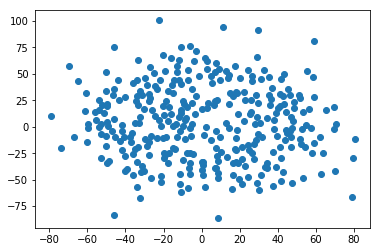

In [29]:
# TSNE

# word-level
X = model[model.wv.vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

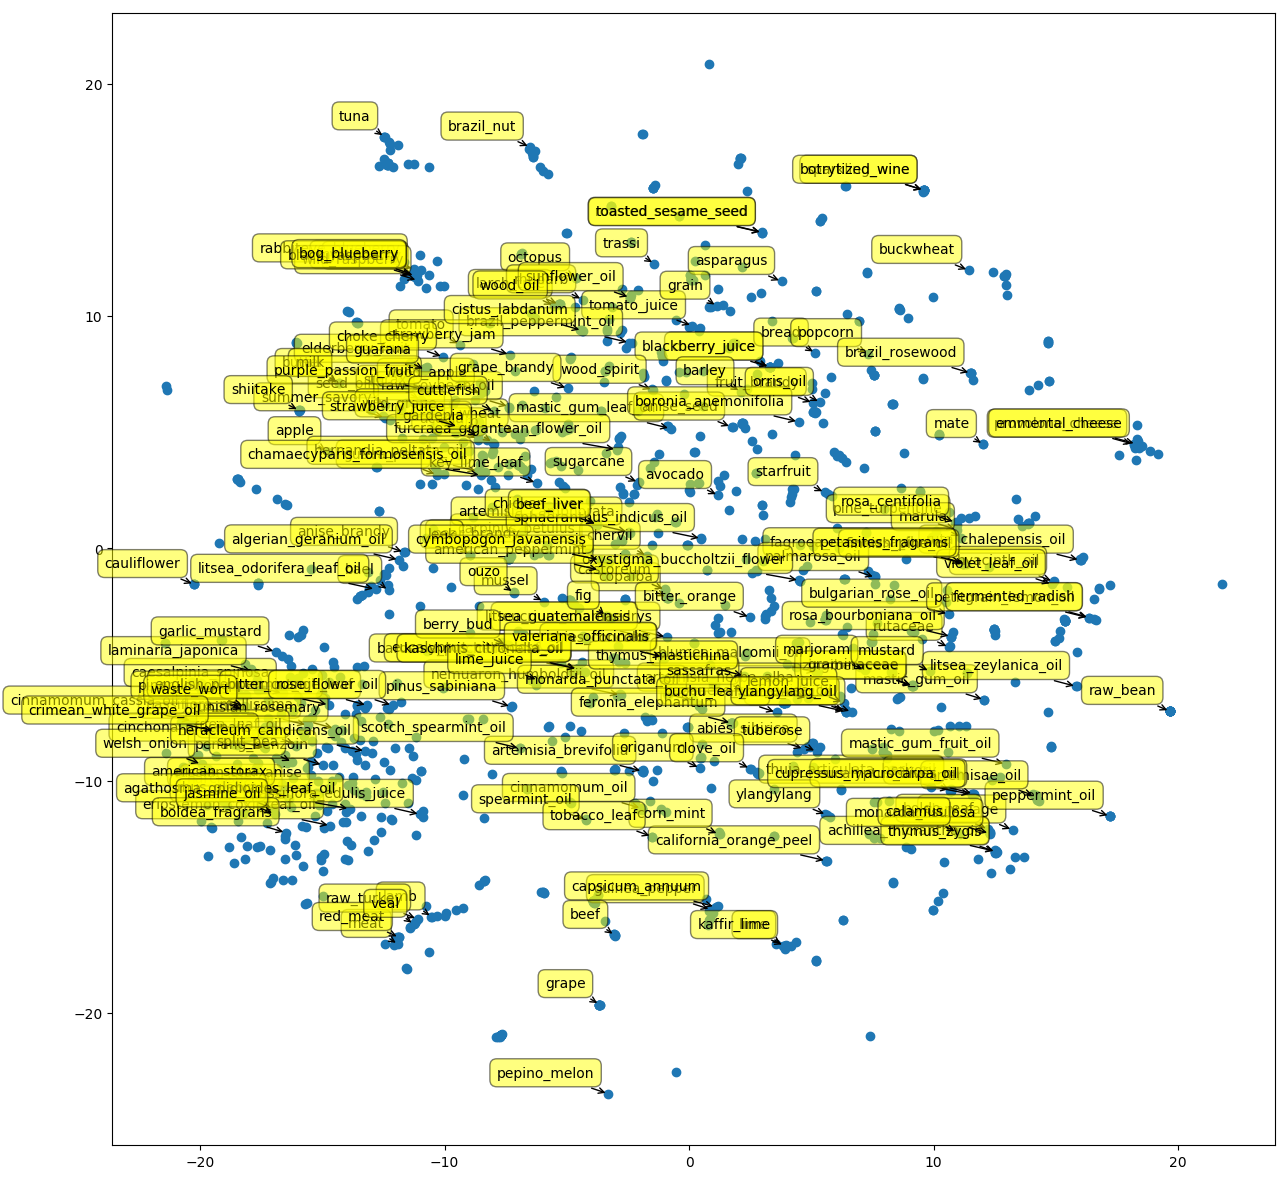

In [73]:
# ingredient-level
X = model.docvecs

labels = []
for i in range(0, len(model.docvecs)):
    labels.append(model.docvecs.index_to_doctag(i))
    
    
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


#define plot size in inches (width, height) & resolution(DPI)
fig = plt.figure(figsize=(15, 15), dpi=100)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

for label, x, y in zip(labels[:200], X_tsne[:, 0][:200], X_tsne[:, 1][:200]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.show()

In [10]:
for i in model.docvecs.indexed_doctags('butter'):
    print i

[]
[[-0.12280162 -0.00451311  0.12690473 ...,  0.06876533 -0.05695188
  -0.17338629]
 [-0.00664265 -0.00622044  0.00451518 ...,  0.00873413  0.00263543
   0.00867833]
 [-0.06617593  0.33063376 -0.19838455 ..., -0.11592285  0.05416442
   0.0115643 ]
 ..., 
 [-0.09835157 -0.07525922  0.10597777 ...,  0.06786586  0.06802031
  -0.2348375 ]
 [-0.27128252 -0.09118522  0.20158942 ...,  0.12255996  0.02811879
  -0.4951013 ]
 [-0.00102201  0.00339739 -0.00154178 ...,  0.00459677  0.006519
   0.00416949]]
[ 1.  1.  1. ...,  1.  1.  1.]
butter


In [59]:
# Pick a random document from the test corpus and infer a vector from the model

doc_id = random.randint(0, len(train_corpus))

inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print label, sims[index]
    #print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))


Train Document (169, cupressus_macrocarpa_oil): [carvomenthenol]

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc20,s0.001,t3):

MOST ('hatsutake', 0.8876945376396179)
MEDIAN ('rhus_cotinus_leaf', 0.5743974447250366)
LEAST ('macadamia_nut', -0.5380587577819824)


In [54]:
# ingredient-level
X = model.docvecs

for i in range(0, len(model.docvecs)):
    labels.append(model.docvecs.index_to_doctag(i))
    
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [52]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline

# Create random data with numpy
import numpy as np

labels = []
for i in range(0, len(model.docvecs)):
    labels.append(model.docvecs.index_to_doctag(i))
   
# Create a trace
trace = go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = labels
)

data = [trace]

# Plot and embed in ipython notebook!
offline.plot(data, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')

'file:///Users/asd/coding/ingredient2vec/basic-scatter.html'